Get the complete data_set, together with the train and test data_set

In [1]:
from tf_chpvk_pv.dataset import *
import pandas as pd

df = create_dataset()

train_df, test_df = train_test_split()

2025-02-04 15:39:24.712 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


2025-02-04 15:39:26.619 | INFO     | tf_chpvk_pv.dataset:create_dataset:37 - Processing dataset...
2025-02-04 15:39:27.703 | SUCCESS  | tf_chpvk_pv.dataset:create_dataset:122 - Processing dataset complete.
2025-02-04 15:39:27.704 | INFO     | tf_chpvk_pv.dataset:train_test_split:132 - Creating train and test dataset...
2025-02-04 15:39:27.721 | SUCCESS  | tf_chpvk_pv.dataset:train_test_split:170 - Creating train and test dataset complete.


Train the SISSO model to obtain the features

In [2]:
from tf_chpvk_pv.features import run_SISSO_model

Inputs = run_SISSO_model()

2025-02-04 15:39:27.746 | SUCCESS  | tf_chpvk_pv.features:run_SISSO_model:66 - SISSO Features were already generated.


Train tree models with the SISSO features, to decide the best t_sisso

2025-02-04 15:44:27.344 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


2025-02-04 15:44:28.750 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((log_rA_rB_ratio - rB_rX_ratio) + (rB_rX_ratio / log_rA_rB_ratio)) * ((1.0 / rB_rX_ratio) + (1.0 / nB)))
Classification tree accuracy (for t_sisso) on the train set: 0.907080.
Classification tree accuracy (for t_sisso) on the train set (5 fold CV): 0.898068.
Classification tree accuracy (for t_sisso) on the test set: 0.929825.
t_sisso < 2.529569 indicates stable perovskites.
Classification tree accuracy (for t) on the train set: 0.637168.
Classification tree accuracy (for t) on the train set (5 fold CV): 0.588116.
Classification tree accuracy (for t) on the test set: 0.614035.
0.832690 < t < 0.868914 indicates stable perovskites.
Classification tree accuracy (for tau) on the train set: 0.845133.
Classification tree accuracy (for tau) on the train set (5 fold CV): 0.840580.
Classification tree accuracy (for tau) on t

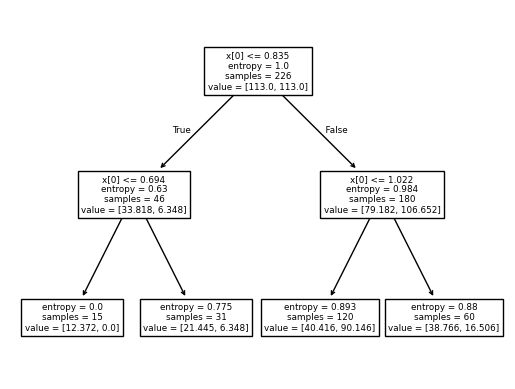

In [ ]:
from tf_chpvk_pv.modeling.train import *

t_sisso_expression = train_tree_sis_features()
train_df, test_df, tolerance_factor_dict = evaluate_t_sisso(t_sisso_expression)

tfs = ['t_sisso', 't', 'tau', 't_jess']
tf_tresh = [1, 2, 1, 2]

df_acc =pd.DataFrame()
clfs = {}

for tf, tresh in zip(tfs, tf_tresh):
    df_acc, clf_t = test_tolerance_factor(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=tresh)
    clfs[tf] = clf_t

In [3]:
train_df, test_df = train_platt_scaling(train_df, test_df, tolerance_factor_dict, clfs['t_sisso'])

2025-02-04 15:46:11.255 | INFO     | tf_chpvk_pv.modeling.train:train_platt_scaling:50 - Training Platt scaling model...
2025-02-04 15:46:11.575 | SUCCESS  | tf_chpvk_pv.modeling.train:train_platt_scaling:70 - Platt scaling model training complete.


Now let's create new possible compositions

In [1]:
from tf_chpvk_pv.dataset import generate_compositions
from tf_chpvk_pv.modeling.predict import check_stable_compositions

elements_selection = ["Si", "Ge", "V", "Rh", "Ti", "Ru", "Mo", "Ta", "Nb",
                        "Sn", "Hf", "Zr", "Tb", "Pb", "Pt", "Ce", "U", "Ba",
                        "Eu", "Sr", "Ca", "Cd", "Cu", "Mg", "Zn", "Ge", "Fe",
                        "Nb", "La", "Pr", "Nd", "Yb", "Gd", "Sm", "Y", "Dy", "Ho",
                        "Er", "Tm", "Lu", "Sc", "Tl", "Bi",  "Pd", "Ni", "Co", "Ga",
                        "Al", "Cr", "In", "V", "Mn", "Tm"]

df_generated_comp = generate_compositions(elements_selection)
stable_candidates_t_sisso, df_out = check_stable_compositions('t_sisso')

2025-02-04 16:29:32.266 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


2025-02-04 16:29:32.964 | INFO     | tf_chpvk_pv.dataset:generate_compositions:204 - Generating valid compositions...
2025-02-04 16:29:39.647 | SUCCESS  | tf_chpvk_pv.dataset:generate_compositions:336 - 950 valid compositions generated.
According to t_sisso, 114 compositions are predicted to be stable as perovskites:
['RhTbS3', 'RhTbSe3', 'RhCeS3', 'RhCeSe3', 'RhUS3', 'RhUSe3', 'RhEuS3', 'RhEuSe3', 'RhLaS3', 'RhLaSe3', 'RhPrS3', 'RhPrSe3', 'RhNdS3', 'RhNdSe3', 'RhYbS3', 'RhYbSe3', 'RhGdS3', 'RhGdSe3', 'RhSmS3', 'RhSmSe3', 'RhYS3', 'RhYSe3', 'RhDyS3', 'RhDySe3', 'RhHoS3', 'RhHoSe3', 'RhErS3', 'RhErSe3', 'RhTmS3', 'RhTmSe3', 'RhLuS3', 'RhLuSe3', 'RhTlS3', 'RhTlSe3', 'RhBiS3', 'RhBiSe3', 'CeNbS3', 'CaNbS3', 'CdNbS3', 'PbCeS3', 'PbCeSe3', 'PbUS3', 'PbUSe3', 'PbPrS3', 'PbPrSe3', 'CeScS3', 'CeInS3', 'CeInSe3', 'BaPrS3', 'BaPrSe3', 'SrPrS3', 'SrPrSe3', 'CaPrS3', 'CaPrSe3', 'CdPrS3', 'CuLaS3', 'CuLaSe3', 'FeLaS3', 'FeLaSe3', 'FePrS3', 'FePrSe3', 'FeNdS3', 'FeNdSe3', 'FeYbS3', 'FeYbSe3', 'FeGdS

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


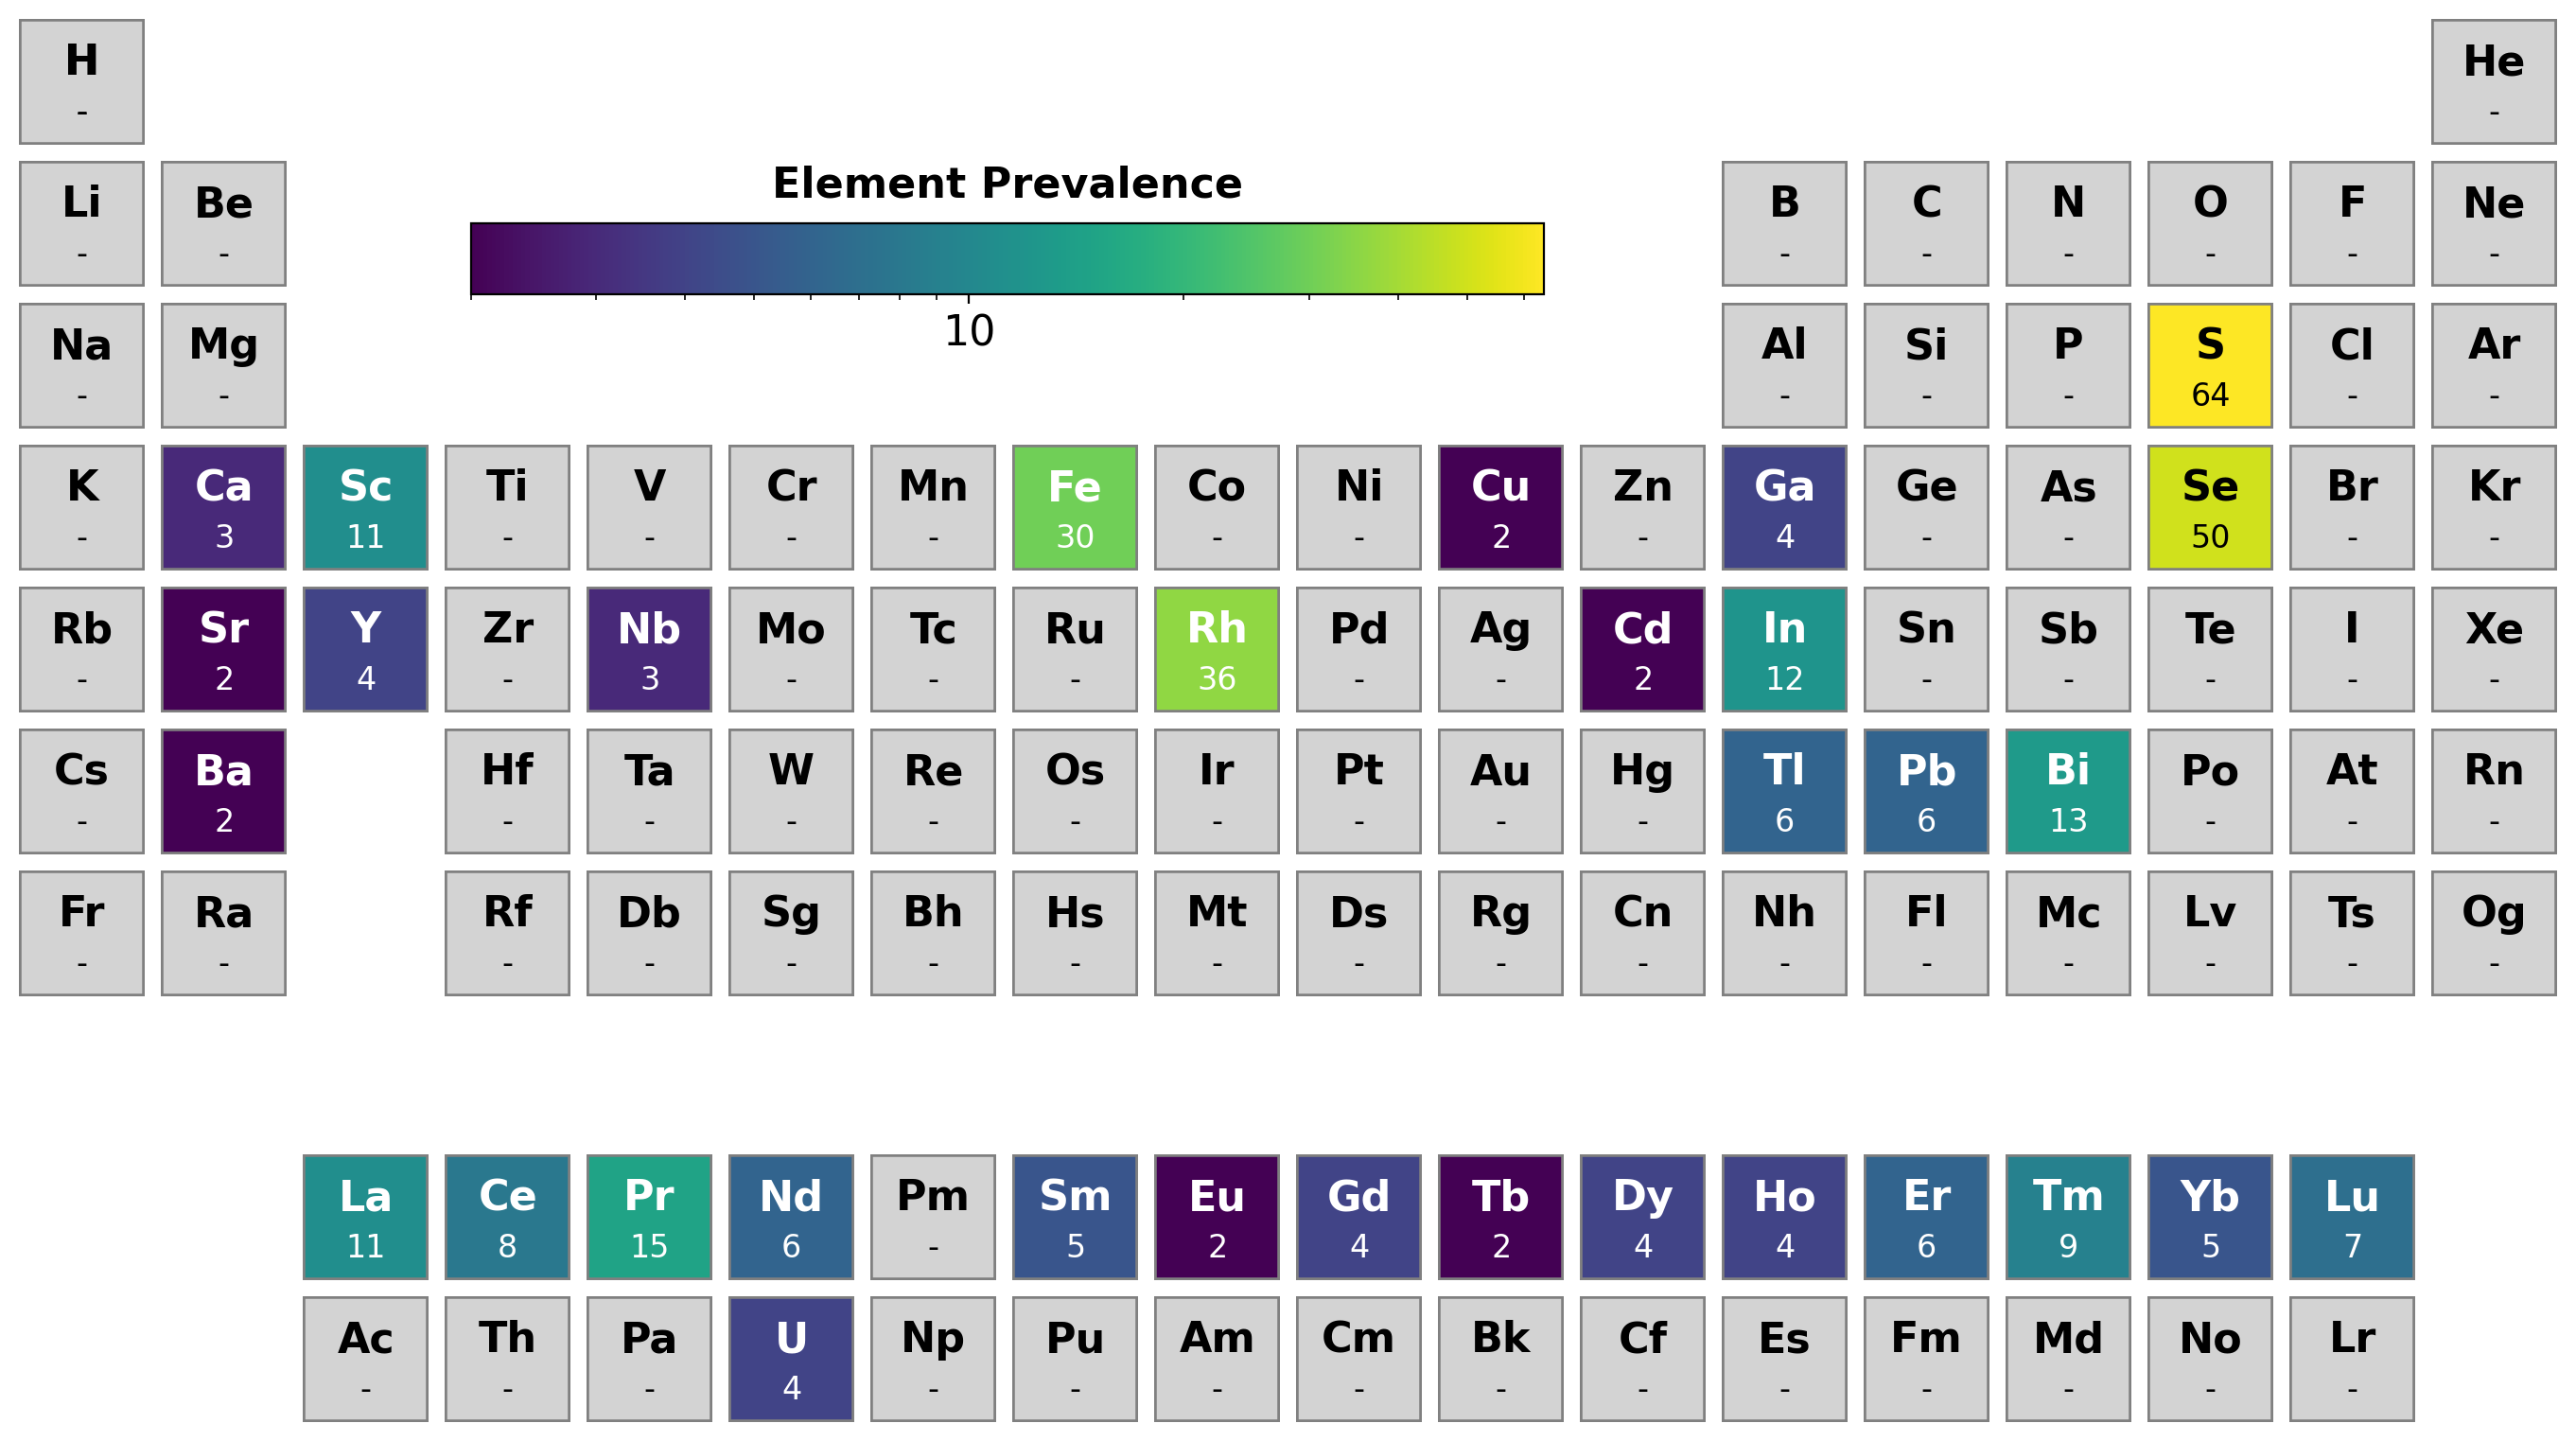

In [2]:
from tf_chpvk_pv.plots import graph_periodic_table

graph_periodic_table(stable_candidates_t_sisso)